In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json
import xarray as xr

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import *

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

from matplotlib import rcParams
rcParams['axes.labelsize'] = 10
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['legend.fontsize'] = 10
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern Roman']
rcParams['text.usetex'] = True

/home/admin-u6015325/ownCloud/git/SynbioML/notebooks/result_analysis
['/home/admin-u6015325/ownCloud/git/SynbioML/notebooks/result_analysis', '/home/admin-u6015325/.vscode/extensions/ms-toolsai.jupyter-2021.5.745244803/pythonFiles', '/home/admin-u6015325/.vscode/extensions/ms-toolsai.jupyter-2021.5.745244803/pythonFiles/lib/python', '/home/admin-u6015325/anaconda3/lib/python37.zip', '/home/admin-u6015325/anaconda3/lib/python3.7', '/home/admin-u6015325/anaconda3/lib/python3.7/lib-dynload', '', '/home/admin-u6015325/anaconda3/lib/python3.7/site-packages', '/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/strkernel-0.2-py3.7.egg', '/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/IPython/extensions', '/home/admin-u6015325/.ipython', '/home/admin-u6015325/ownCloud/git/SynbioML']


In [3]:
# generate valids names and path for plots

def valid_name(name):
    return name.replace('_', ' ')  
def valid_path(path):
    return path.replace(' ', '_')

folder_path = '../../data/pipeline_data/'

In [7]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

color_dict = {}

viridis = cm.get_cmap('viridis', 5)
tab10 = cm.get_cmap('tab10', 10)

color_dict['consensus'] = tab10.colors[1]
color_dict['reference'] = tab10.colors[3]
color_dict['bps_core'] = tab10.colors[5]
color_dict['bps_noncore'] = tab10.colors[6]
color_dict['uni random'] = tab10.colors[7]
color_dict['prob random'] = tab10.colors[8]
color_dict['bandit'] = viridis.colors[0]
color_dict['bandit2'] = viridis.colors[1]
color_dict['bandit3'] = viridis.colors[2]
color_dict['bandit4'] = viridis.colors[3]

In [27]:
sns.set_palette(list(color_dict.values())[1:])

In [5]:
df_e1 = pd.read_csv(folder_path + 'Results_e1.csv')
df_e1.head()

,Name,Group,Plate,Round,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,AVERAGE,STD
0,RBS_1by1_0,Reference,First_Plate,0,TTTAAGAAGGAGATATACAT,AGGAGA,1.234425,0.799396,1.505974,0.940042,0.826077,0.694087,1.000000,0.309397
1,RBS_1by1_1,BPS-NC,First_Plate,0,CTTAAGAAGGAGATATACAT,AGGAGA,0.889925,0.611310,1.237727,0.641361,0.693063,0.625539,0.783154,0.245207
2,RBS_1by1_2,BPS-NC,First_Plate,0,GTTAAGAAGGAGATATACAT,AGGAGA,0.591597,0.439823,0.896431,0.373561,0.368157,0.390475,0.510007,0.206849
3,RBS_1by1_3,BPS-NC,First_Plate,0,ATTAAGAAGGAGATATACAT,AGGAGA,0.926292,0.657386,1.138099,0.589480,0.580444,0.482180,0.728980,0.250547
4,RBS_1by1_4,BPS-NC,First_Plate,0,TCTAAGAAGGAGATATACAT,AGGAGA,0.886305,0.700403,1.075955,0.676601,0.585711,0.665753,0.765121,0.181873


# Swarmplot

Text(0.5, 1.0, 'Swarmplot with TIR Labels (ratio)')

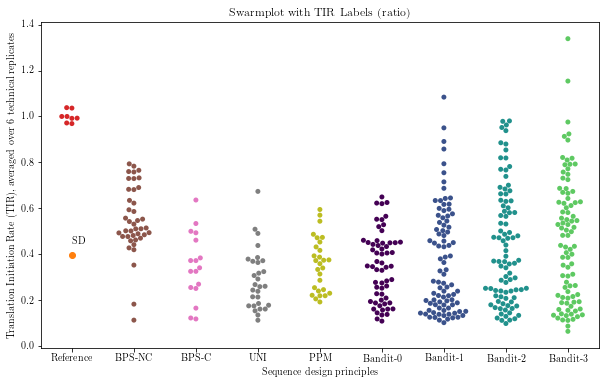

In [43]:
f, axes = plt.subplots(1, 1, figsize=(10, 6), sharex=False)
sns.swarmplot(x = 'Group', y = 'AVERAGE', data = df_e1, ax = axes, order=['Reference', 'BPS-NC', 'BPS-C', 'UNI', 'PPM', 'Bandit-0', 'Bandit-1', 'Bandit-2', 'Bandit-3'])
y = df_e1[df_e1['Group'] == 'Consensus']['AVERAGE']
axes.scatter(x = 0, y = y, color = color_dict['consensus'])
axes.text(0, y + 0.05, 'SD')
axes.set(xlabel='Sequence design principles', ylabel='Translation Initiation Rate (TIR),\\ averaged over 6 technical replicates')
axes.set_title('Swarmplot with TIR Labels (ratio)')

# Quantile plot

In [49]:
df_e1['Group2'] = df_e1['Group']
df_e1.loc[df_e1['Group2'] == 'UNI', 'Group2'] = 'Random'
df_e1.loc[df_e1['Group2'] == 'PPM', 'Group2'] = 'Random'

In [84]:

def quant_line(df, col = 'Group', title = 'Quantile of groups'):
    f, axes = plt.subplots(1, 1, figsize=(10, 6), sharex=False)
    quantile_levels = [0.9, 0.8, 0.7, 0.6, 0.5]
    used_groups = ['BPS-C', 'Random', 'Bandit-0', 'Bandit-1', 'Bandit-2', 'Bandit-3']
    df_bandits = df.loc[df[col].isin(used_groups)]

    quant_dict = defaultdict(list)
    groups = df_bandits.groupby(col)
    sns.set_palette('viridis') 

    for used_group in used_groups:
        quant_dict['max'].append(groups.get_group(used_group)['AVERAGE'].max())
    axes.plot(range(len(used_groups)), quant_dict['max'], marker = '.', label = 'max', alpha = 0.8, color = 'orange')

    for quant in quantile_levels:
        for used_group in used_groups:
            quant_dict[quant].append(groups.get_group(used_group)['AVERAGE'].quantile(quant))
        axes.plot(range(len(used_groups)), quant_dict[quant], marker = '.', label = str(quant), alpha = 0.8)
 
    # plt.plot(df_bandits.sort_values('AVERAGE',ascending=False).groupby(col).nth(4)['AVERAGE'], marker = '.', label = 'Top-5', alpha = 0.6)
    plt.legend()
    plt.xticks(range(len(used_groups)), used_groups)
    plt.title(title)

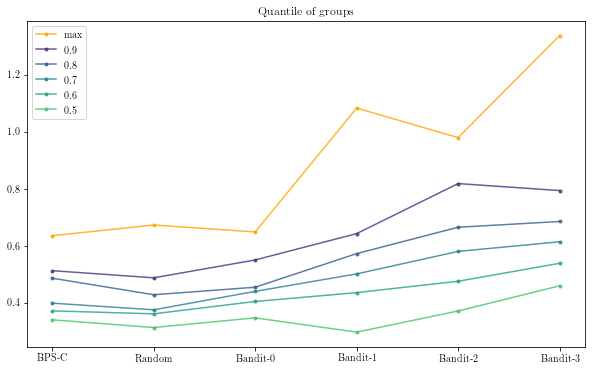

In [85]:
quant_line(df_e1, 'Group2')

# Scatterplot